Functions definitions and importing the modules

In [423]:
#!interpreter [python3]
# -*- coding: utf-8 -*-

"""
Script for calculating the availability of a given network.

The necessary data are: shapefile of the network and shapefiles of the segments 
of the network interested by limitations (slow-speed segments, construction sites.)

The script outputs tables of the yearly and monthly availabilities,
as well as charts thereof.

For the yearly data, only years before the current one are taken into consideration
(the current year is excluded.)
Similarly, for the monthly data, only months before the current one are taken into consideration
(months after the current one, current one included, are excluded.)
"""

__author__ = 'Luca Iacolettig'
__copyright__ = 'Copyright 2022'
__email__ = 'iacolettig.luca@gmail.com'
__version__ = '1.4'
__license__ = 'GNU GPL v3'

#
# Import modules
#
import pandas as pd
import geopandas as gpd
import shapefile
from osgeo import osr # install gdal first! https://pypi.org/project/GDAL/
from shapely.geometry import shape, LineString
import numpy as np
import openpyxl  
import calendar
import datetime
import matplotlib.pyplot as plt
import warnings
from types import SimpleNamespace

#import language dictionaries from the child directory 
# .\languages\
from languages.en import en
from languages.de import de
from languages.fr import fr
from languages.it import it




#
# Defining classes and functions
#

# class for multiple language support
class NestedNamespace(SimpleNamespace):
    def __init__(self, dictionary, **kwargs):
        super().__init__(**kwargs)
        for key, value in dictionary.items():
            if isinstance(value, dict):
                self.__setattr__(key, NestedNamespace(value))
            else:
                self.__setattr__(key, value)

# initialise a text variable for accessing the dictionaries                
text = {}
text.update({"en": NestedNamespace(en)})
text.update({"de": NestedNamespace(de)})
text.update({"fr": NestedNamespace(fr)})
text.update({"it": NestedNamespace(it)})


def readData(file):
    """Reads from csv file using Pandas
    
    Parameters
    ----------
    file : str
        The file location of the csv file

    Returns
    -------
    pd.read_csv(file)
        The read csv file by Pandas
    """

    return pd.read_csv(file)

def saveData(dfs, outputFileName, sheet_names = 'sheet_1'):
    """Saves the data in one or multiple sheets to an Excel outputFileName
    
    Parameters
    ----------
    dfs : DataFrame, list
        The DataFrame or the list of DataFrames to be saved
    outputFileName : str
        The file location of the output xlsx file
    sheet_names : list
        List of the strings of the names of the sheets relative to the DataFrames in the list
        of dfs. The length of sheet_names must be equal to the length of dfs.

    Returns
    -------
    dfs.to_excel(outputFileName, sheet_name=sheet_names, index=False)
        The Excel file of the DataFrame df
        Does not keep the index of the DataFrame
    """
    # if dfs is a single dataframe, create an excel file with a single sheet
    if isinstance(dfs, pd.DataFrame):
        return dfs.to_excel(outputFileName, sheet_name=sheet_names, index=False) 
    # otherwise, if dfs is a list, create an excel file with multiple sheets
    # the list must be composed of dataframes
    elif isinstance(dfs, list):
        # create an excel writer object
        with pd.ExcelWriter(outputFileName) as writer:
            for i in range(len(dfs)):
                # use to_excel function and specify the sheet_name and index
                # to store the dataframe in specified sheet
                dfs[i].to_excel(writer, sheet_name=sheet_names[i], index=False)
    # if dfs is neither a DataFrame nor a list, raise an exception
    else:
        raise Exception("Error: You are trying to save data that is neither a dataframe nor a list of dataframes.")
        
def countDays(date1, date2):
    """Calculates the number of days between two dates.
    Dates can be put in whatever order wished thanks to the abs function.

    Parameters
    ----------
    date1 : datetime
        First date
    date2 : datetime
        Second date

    Returns
    -------
    delta
        Number of days between date1 and date2, extremes included
    """
    
    days = abs((date2 - date1) / np.timedelta64(1, 'D')) + 1
    return days

def makeDate(datestring):
    """Converts a string to a date

    Parameters
    ----------
    datestring : str
        The string that wants to be converted into date

    Returns
    -------
    date
        String converted into a date
    """

    date = pd.to_datetime(datestring)
    return date

def SHPtoGeodataframe(shp):
    """Converts an ESRI shapefile to a Geopandas geodataframe
    
    Parameters
    ----------
    shp : str
        Name of the shapefile (without extension) to be converted into a GeoDataframe
        
    Returns
    -------
    gdf
        Converted Geopandas geodataframe from the input shapefile
    """
    # read the shapefile
    tracts = shapefile.Reader(shp+'.shp')
    
    # get the fields of the shapefile using a list comprehension
    fields = [field[0] for field in tracts.fields[1:]]
    
    # initalise two lists for the attributes and the geometries
    attributes = []
    geometry = []

    # append attributes and geometries
    for row in tracts.shapeRecords():
        geometry.append(shape(row.shape.__geo_interface__))
        attributes.append(dict(zip(fields, row.record)))
    
    # set the coordinates reference system for the data from the prj file
    with open(shp+'.prj') as p:
        proj4 = osr.SpatialReference(p.read()).ExportToProj4()
    # create the geodataframe
    gdf = gpd.GeoDataFrame(data=attributes, geometry=geometry, crs=proj4)
    return gdf

def WKBtoGeodataframe(df, geometry_col, epsg):
    """Converts a Pandas dataframe with a WKB geometry column into a Geopandas geodataframe

    Parameters
    ----------
    df : DataFrame
        DataFrame that want to be converted into a GeoDataframe
    geometry_col : str
        Name of the WKB geometry column in df
    epsg : str
        EPSG of the coordinate reference system of the geometry features in format 'epsg:nnnn'

    Returns
    -------
    geodataframe
        The converted GeoPandas Geodataframe
    """
    gdf = gpd.GeoDataFrame(
    df.loc[:, [c for c in df.columns if c != geometry_col]], # select non-geometry columns only
    geometry=gpd.GeoSeries.from_wkb(df[geometry_col]), # create geometry column from wkb data
    crs=epsg
    )
    return gdf

def first_last_days(year):
    """Creates two lists of dates of the first and the last days of every month given an input year with the format
    YYYY-MM-DD
    
    Parameters
    ----------
    year : int
        The year we want to get the first and last days of every month from

    Returns
    -------
    first_days
        List of the dates of the first days of every month 
    last_days
        List of the dates of the last days of every month
    """
    first_days = pd.to_datetime([str(year) + '-' + str(i+1).zfill(2) + '-01' for i in range(12)])
    last_days = pd.to_datetime([str(year) + '-' + str(i+1).zfill(2) + '-' + str(calendar.monthrange(year, i+1)[1]).zfill(2) for i in range(12)])
    return [first_days, last_days]

def start_end_year(year):
    """
    Creates a list of dates of the first and the last day of a given input year in format YYYY-MM-DD
    
    Parameters
    ----------
    year : int
        The year we want to get the first and last days from
        
    Returns
    -------
    start_year
        Date of the first day of a give year
    end_year
        Date of the last day of a give year
    """
    start_year = pd.to_datetime(str(year) + '-01-01')
    end_year = pd.to_datetime(str(year) + '-12-31')
    return [start_year, end_year]

def getCurrentYear():
    """Gets the year (Gregorian calendar) we are currently in
    
    Returns
    -------
    current_year
        The year we are currently in in format YYYY
    """
    currentDateTime = datetime.datetime.now()
    date = currentDateTime.date()
    current_year = date.strftime("%Y")
    return current_year

def getCurrentMonth():
    """Gets the month we are currently in
    
    Returns
    -------
    current_month
        The month we are currently in in format MM
    """
    currentDateTime = datetime.datetime.now()
    date = currentDateTime.date()
    current_month = date.strftime("%m")
    return current_month

def calculateTotalLength(gdf):
    """Calculates the total length (sum of all segments) of a geodataframe
    
    Parameters
    ----------
    gdf : GeoDataFrame
        A GeoDataFrame
        
    Returns
    -------
    total_length
        Total length (sum) of the lines of the GeoDataFrame
    """
    # Calculate length of the net
    gdf['geom_length'] = gdf.geometry.length
    # Decomment the following lines to select only segments with a set date and that are not (~) to be avoided
    # Insert the appropriate arguments in the function calculateTotalLength after 'gdf' (arguments to be inserted: date_col, date, ids_col, avoid_ids)
    # gdf_active = gdf.loc[(gdf[date_col] == date)]
    # gdf_active = gdf.loc[(~gdf[ids_col].isin(avoid_ids))]
    total_length = gdf['geom_length'].sum()
    # Comment the above line and decomment the following line if needed after the creation of gdf_active
    # total_length = gdf_active['geom_length'].sum()

    return total_length

def daysInPeriod(row, start_col, end_col, init_date, finish_date):
    """Calculates how many days there are in a time period between init_date and finish_date

    Parameters
    ----------
    row : DataFrame
        Single element (row) of a DataFrame
    start_col : str
        Name of the column with dates to start with
    end_col : str
        Name of the column with dates to end with
    init_date : datetime
        Date of beginning of a certain period
    finish_date : datetime
        Date of end of a certain period 

    Returns
    -------
    days
        Number of days between two dates (extremes included) 
        if they fall within the time period
    """
    # four cases have to be considered
    if row[start_col] < init_date and row[end_col] > finish_date:
        days = countDays(finish_date, init_date)
    elif row[start_col] < init_date and row[end_col] <= finish_date:
        days = countDays(row[end_col], init_date)
    elif row[start_col] >= init_date and row[end_col] > finish_date:
        days = countDays(finish_date, row[start_col])
    else:
        days = countDays(row[end_col], row[start_col])
    return days

def last_prev_month(date):
    """
    Finds the last day of the previous month given a date (timestamp)
    """
    return date.replace(day=1) - datetime.timedelta(days=1)

def first_next_month(date):
    """
    Finds the first day of the next month given a date (timestamp)
    """
    if date.month == 12:
        return date.replace(day=1, month=1, year=date.year + 1)
    return date.replace(day=1, month=date.month + 1)

def calculationsAvailability(segments, start_col, end_col, start_date, end_date, length_net):
    """Calculates the availability given a certain length of the net and certain segments
    that influence the availability. All this within a certain period between start_date and end_date
    
    Parameters
    ----------
    segments : GeoDataFrame
        GeoDataFrame of the segments to calculate the availability with. 
        It must have two columns with the dates of when a certain segment started in time
        and when it ended. A segment can be e.g. due to a construction site.
    start_col : str
        Name of the column with dates to start with
    end_col : str
        Name of the column with dates to end with 
    start_date : datetime
        Date of beginning of a certain period
    end_date : datetime
        Date of end of a certain period 
    length_net : float64
        Length of the whole net

    Returns
    -------
    net_availability
        Availability of the net
    """
    # creates a Boolean Series that is True when the start_date is less than or equal to the segment's start_col AND 
    # when the end_date is greater than or equal to the segment's end_col
    period = (segments[start_col] <= end_date) & (segments[end_col] >= start_date)
    segments_period = segments.loc[period]

    segments_period = segments_period.copy()
    
    # if the period of the segments has no data, assign None to both the days count and the geometry length
    if segments_period.shape[0] == 0:
        segments_period['count_days_period'] = None
        segments_period['geom_length'] = None
    # otherwise, calculate how many days there are in a certain period and calculate the respective geometry length
    else:
        segments_period['count_days_period'] = segments_period.apply(lambda x: daysInPeriod(x, start_col, end_col, start_date, end_date), axis=1)
        segments_period['geom_length'] = segments_period.geometry.length
    
    # calculates the fraction between count_days_period and how many days there are between end and start_date
    segments_period['days_fraction'] = segments_period['count_days_period'] / countDays(end_date, start_date)     
    # weigh the length of every segment according to its weigh in days 
    segments_period['length_weighted'] = segments_period['days_fraction'] * segments_period['geom_length']

    # Sum all weighted lengths and calculate the availability
    segments_length_weighted = segments_period['length_weighted'].sum()
    availability = (length_net - segments_length_weighted) / length_net
    
    return availability

def calculateAvailabilityYear(start_col, end_col, segments, length_net, yearName='year', availabilityName='availability'):
    """
    Generates a table of the yearly availability of the net.
    It outputs one value of availability for every year of the segments geodataframe
    
    Parameters
    ----------
    start_col : str
        Name of the column of the geodataframe with dates to start with
    end_col : str
        Name of the column of the geodataframe with dates to end with 
    segments : GeoDataFrame
        GeoDataFrame of the segments to calculate the availability with
    length_net : float64
        Length of the whole net
    yearName : str
        Name to give to the colum "year". Useful for multiple languages, default 'year'
    availabilityName : str
        Name to give to the colum "availability". Useful for multiple languages, default 'availability'
    
    Returns
    -------
    table_year
        Pandas DataFrame of the yearly availability of the net for all years present in segments. 
        It has the columns relative to the year and to the availability.
    """
    
    # calculates minimum and maximum year present in the segments geodataframe
    minyear = segments[start_col].min().year
    maxyear = segments[end_col].max().year
    
    # if the maximum year of the geodataframe is the current year or a higher one, exclude it from the calculations
    if maxyear >= int(getCurrentYear()):
        maxyear = int(getCurrentYear()) - 1

    # initalise an empty list for the geodataframe of the yearly availabilities
    append_table_year = []
    
    # cycle over all years in the dataset
    for year in range(minyear, maxyear+1): 
    
        # Empty lists to be filled with data
        year_col = []
        availability_col = []
        
        # first and last day of the year
        first_day_year = start_end_year(year)[0]
        last_day_year = start_end_year(year)[1]
        
        # calculate the availbility of one year
        net_availability_year = calculationsAvailability(segments, start_col, end_col, first_day_year, last_day_year, length_net)
        
        # populate the lists with the year and the availability number
        year_col.append(year)
        availability_col.append(net_availability_year)
        
        # make dataframes
        year_col = pd.DataFrame(year_col)
        availability_col = pd.DataFrame(availability_col)
        
        # rename the columns. Default 'year' and 'availability'
        year_col.rename(columns = {0:yearName}, inplace = True)
        availability_col.rename(columns = {0:availabilityName}, inplace = True)
        
        # make a unique dataframe
        availability_table = pd.concat([year_col, availability_col], axis=1)
        
        # append the data to the list initialised above
        append_table_year.append(availability_table)
        table_year = pd.concat(append_table_year).reset_index(drop=True)

    return table_year

def calculateAvailabilityMonth(start_col, end_col, segments, length_net, yearName='year', monthName='month', availabilityName='availability'):
    """
    Generates monthly tables of the availability of the net.
    It outputs one value of availability for every month of every year of the segments geodataframe

    Parameters
    ----------
    start_col : str
        Name of the column with dates to start with
    end_col : str
        Name of the column with dates to end with 
    segments : GeoDataFrame
        GeoDataFrame of the segments to calculate the availability with
    length_net : float64
        Length of the whole net
    yearName : str
        Name to give to the colum "year". Useful for multiple languages, default 'year'
    monthName : str
        Name to give to the colum "month". Useful for multiple languages, default 'month'
    availabilityName : str
        Name to give to the colum "availability". Useful for multiple languages, default 'availability'

    Returns
    -------
    table_month
        Pandas DataFrame of the monthly availability of the net for all years present in segments. 
        It has columns relative to the year, month, and availability.
    """
    
    # calculate minimum and maximum dates and years given the segment dataset in input
    mindate = segments[start_col].min()
    maxdate = segments[end_col].max()
    minyear = mindate.year
    maxyear = maxdate.year
    
    # if the maximum year of the geodataframe is higher than the current one, exclude higher years from the calculations
    if maxyear > int(getCurrentYear()):
        maxyear = int(getCurrentYear())
  
    # initalise an empty table 
    append_table_month = []
    
    # Cycle over all years of the dataset, excluding no one
    for year in range(minyear, maxyear+1):
        
        # Empty lists for the data to calculate
        year_col = []
        month_col = []
        availability_col = []
        
        # Cycle over all months
        for i in range(12):
            # calculate first and last day of every month
            first_day_month = first_last_days(year)[0][i]
            end_day_month = first_last_days(year)[1][i]
            
            # if the first or the last day of the month fall outside of the range of the minimum and maximum date of 
            # the dataset, give None to the net availability
            if first_day_month <= last_prev_month(mindate) or end_day_month >= first_next_month(maxdate):
                net_availability_month = None 
            # otherwise, calculate the availability
            else:
                net_availability_month = calculationsAvailability(segments, start_col, end_col, first_day_month, end_day_month, length_net)
            
            # append the data to the initalised lists
            year_col.append(year)
            month_col.append(first_day_month.month)
            availability_col.append(net_availability_month)

        # make dataframes
        year_col = pd.DataFrame(year_col)
        month_col = pd.DataFrame(month_col)
        availability_col = pd.DataFrame(availability_col)
        
        # rename the column. Default 'year', 'month', 'availability'
        year_col.rename(columns = {0:yearName}, inplace = True)
        month_col.rename(columns = {0:monthName}, inplace = True)
        availability_col.rename(columns = {0:availabilityName}, inplace = True)
        
        # make a unique dataframe
        availability_table_month = pd.concat([year_col, month_col, availability_col], axis=1)
        
        # append all the data
        append_table_month.append(availability_table_month)
        
    table_month = pd.concat(append_table_month).reset_index(drop=True)
    
    # Select only the data before the current month of the current year
    table_month['yearmonth'] = table_month[yearName].astype(str) + table_month[monthName].astype(str)
    table_month['yearmonth'] = table_month['yearmonth'].astype(int)
    table_month = table_month[table_month.yearmonth < int(getCurrentYear()+getCurrentMonth())]
    table_month.drop('yearmonth', axis=1, inplace=True)
    table_month = table_month.dropna(axis='rows', how='any') # remove nan rows
    
    return table_month

def calculateAvailabilityConstructionSites(gdf_sites, start_col, end_col, length_net, yearName, monthName, availabilityName, typeCol='type', totalBlockName='total block'):
    """Calculates the availability of the construction sites, dividing between total-block construction sites
    and slow-speed construction sites.
    Construction sites that are not total-block sites are considered to be slow-speed sites
    
    Parameters
    ----------
    gdf_sites : GeoDataFrame
        GeoDataFrame of the construction sites. It must have a column with type of the 
        construction site specified
    typeCol : str
        Name of the column with the type of the construction site.
        Default 'type'
    totalBlockName : str
        Denomination of the total blocks.
        Default 'total block'
    start_col : str
        Name of the column with starting dates of the construction sites
    end_col : str
        Name of the column with ending dates of the construction sites

    Returns
    -------
    availability_sites_total_block_year
        Yearly availability data of the total-block construction sites
    availability_sites_slow_tracks_year
        Yearly availability data of the slow-speed construction sites
    availability_sites_total_block_month
        Monthly availability data of the total-block construction sites
    availability_sites_slow_tracks_month
        Monthly availability data of the slow-speed construction sites
    """
    ## Total block construction sites
    # Select total-block construction sites only
    gdf_sites_total_block = gdf_sites[gdf_sites[typeCol] == totalBlockName]
    # Yearly availability
    availability_sites_total_block_year = calculateAvailabilityYear(start_col, end_col, gdf_sites_total_block, length_net, yearName, availabilityName)
    # Monthly availability
    availability_sites_total_block_month = calculateAvailabilityMonth(start_col, end_col, gdf_sites_total_block, length_net, yearName, monthName, availabilityName)
    
    ## Slow-speed construction sites
    # Select non-total-block construction sites only
    gdf_sites_slow_tracks = gdf_sites[gdf_sites[typeCol] != totalBlockName]
    # Yearly availability
    availability_sites_slow_tracks_year = calculateAvailabilityYear(start_col, end_col, gdf_sites_slow_tracks, length_net, yearName, availabilityName)
    # Monthly availability
    availability_sites_slow_tracks_month = calculateAvailabilityMonth(start_col, end_col, gdf_sites_slow_tracks, length_net, yearName, monthName, availabilityName)
    
    return availability_sites_total_block_year, availability_sites_slow_tracks_year, availability_sites_total_block_month, availability_sites_slow_tracks_month

def calculateAvailabilitySlowTracks(df_tracks, df_slow_sites, yearName='year', monthName='month', availabilityName='availability'):
    """Calculates the combined availability of slow tracks and slow-speed construction sites,
    or the single availability of either of the two dataframes, if the other one does not have data for the period considered
    
    Parameters
    ----------
    df_tracks : DataFrame
        DataFrame of the slow tracks
    df_slow_sites : DataFrame
        DataFrame of the slow-speed construction sites
    yearName : str
        Name to give to the colum "year". Useful for multiple languages, default 'year'
    monthName : str
        Name to give to the colum "month". Useful for multiple languages, default 'month'
    availabilityName : str
        Name to give to the colum "availability". Useful for multiple languages, default 'availability'

    Returns
    -------
    table_slow_tracks_both
        DataFrame of the combined availability of slow tracks and slow-speed construction sites
    table_slow_tracks_onlytracks
        DataFrame of the availability of the slow tracks only, if no combined data are available
    table_slow_tracks_onlysites
        DataFrame of the availability of the slow-speed construction sites only, if no combined data are available
    """
    # rename the columns to tell dataframes apart
    df_tracks.rename(columns = {availabilityName:'availability_tracks'}, inplace = True)
    df_slow_sites.rename(columns = {availabilityName:'availability_slow_sites'}, inplace = True)

    # outer join (all data is preserved) between the two tables
    # for the monthly data
    if monthName in df_tracks.columns and monthName in df_slow_sites.columns:
        table_slow_tracks_outer = pd.merge(df_tracks, df_slow_sites, on = [yearName, monthName], how = "outer")
    # for the yearly data
    else:
        table_slow_tracks_outer = pd.merge(df_tracks, df_slow_sites, on = yearName, how = "outer")

    ## table with the combined data from both tables
    table_slow_tracks_both = table_slow_tracks_outer.dropna(axis='rows', how='any') # remove nan values
    table_slow_tracks_both = table_slow_tracks_both.copy()
    # calculate the combined availability
    table_slow_tracks_both[availabilityName] = 1 - ((1 - table_slow_tracks_both['availability_slow_sites']) + (1 - table_slow_tracks_both['availability_tracks']))
    table_slow_tracks_both.drop(['availability_tracks', 'availability_slow_sites'], axis=1, inplace=True)

    ## table of the slow tracks only
    # get only the rows with data that the other column (availability_slow_sites) does not have
    table_slow_tracks_onlytracks = table_slow_tracks_outer[table_slow_tracks_outer['availability_slow_sites'].isna()] 
    table_slow_tracks_onlytracks = table_slow_tracks_onlytracks.dropna(axis='columns', how='all') # remove columns with nan only
    table_slow_tracks_onlytracks = table_slow_tracks_onlytracks.dropna(axis='rows', how='any') # remove nan rows
    table_slow_tracks_onlytracks.rename(columns = {'availability_tracks':availabilityName}, inplace = True)
    table_slow_tracks_onlytracks = table_slow_tracks_onlytracks.reset_index(drop=True)

    ## table of the slow-speed construction sites only
    # get only the rows with data that the other column (availability_tracks) does not have
    table_slow_tracks_onlysites = table_slow_tracks_outer[table_slow_tracks_outer['availability_tracks'].isna()]
    table_slow_tracks_onlysites = table_slow_tracks_onlysites.dropna(axis='columns', how='all') # remove columns with nan only
    table_slow_tracks_onlysites = table_slow_tracks_onlysites.dropna(axis='rows', how='any') # remove nan rows
    table_slow_tracks_onlysites.rename(columns = {'availability_slow_sites':availabilityName}, inplace = True)
    table_slow_tracks_onlysites = table_slow_tracks_onlysites.reset_index(drop=True)

    # Restore original column names
    df_tracks.rename(columns = {'availability_tracks':availabilityName}, inplace = True)
    df_slow_sites.rename(columns = {'availability_slow_sites':availabilityName}, inplace = True)
    
    # Final tables of slow-speed segments (combined or separated)
    return table_slow_tracks_both, table_slow_tracks_onlytracks, table_slow_tracks_onlysites

def plot_yearly_chart(df, xlims, title='yearly_chart', file='yearly_chart.jpg', yearName='year', availabilityName='availability', xlabel='availability', ylabel='year'):
    """Plots a horizontal bar chart based on df and saves it in file
    
    Parameters
    ----------
    df : DataFrame
        The DataFrame that wants to be plotted. It has to have one 
        column with year data and one column with the availability data
    title : str
        Title of the chart
    xlims : tuple
        Tuple of two floats representing the x-axis limits
    file : str
        The file path of the image, extension included (png, pdf, jpg...), that wants to be 
        exported
    xlabel : str
        Label for the x axis. Default 'availability'
    ylabel : str
        Label for the y axis. Defaul 'year'
    """
    # If there are no data in the dataframe raise a warning message
    if df.shape[0] == 0:
        warnings.warn("Warning: I cannot plot the data for an empty table: There is no data to show!\nOne table has not been plotted due to the lack of data.")
    # Otherwise plot the dataframe
    else:
        # Set the figure Size
        fig, ax = plt.subplots(figsize=(16, 9))

        # Convert int year to str
        df[yearName] = df[yearName].astype('string')

        # Create horizontal bars
        ax.barh(df[yearName], df[availabilityName], color='green');
        plt.xlim(xlims)

        # Add padding between axes and labels
        ax.xaxis.set_tick_params(pad=5)
        ax.yaxis.set_tick_params(pad=10)

        # Add x, y gridlines
        ax.grid(visible=True, color='grey',
                linestyle='-.', linewidth=0.5,
                alpha=0.2)

        # Show top values
        ax.invert_yaxis()

        # Title
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)

        # Save the figure to the declared output
        plt.savefig(file, dpi=300)

def plot_monthly_chart(df, ylims, title='monthly_chart', file='monthly_chart.jpg', yearName='year', monthName='month', availabilityName='availability', xlabel='availability', ylabel='month'):
    """Plots several line charts based on df, tracks, start_col, and end_col and saves it in file
    
    Parameters
    ----------
    df : DataFrame
        The DataFrame that wants to be plotted. It has to have one 
        column with year data, one column with month data, and one column with the availability data
    tracks : GeoDataFrame
        GeoDataFrame of the segments used to calculate the availability
    start_col : str
        Name of the column with dates to start with
    end_col : str
        Name of the column with dates to end with 
    title : str
        Title of the output image
    xlabel : str
        Label for the x axis
    ylabel : str
        Label for the y axis
    ylims : tuple
        Tuple of two floats representing the y-axis limits
    file : str
        The file path of the image, extension included (png, pdf, jpg...), that wants to be 
        exported
    yearName : str
        Name to give to the colum "year". Useful for multiple languages, default 'year'
    monthName : str
        Name to give to the colum "month". Useful for multiple languages, default 'month'
    availabilityName : str
        Name to give to the colum "availability". Useful for multiple languages, default 'availability'
    """
    # If there are no data to show, raise a warning message
    if df.shape[0] == 0:
        warnings.warn("Warning: I cannot plot the data for an empty table: There is no data to show!\nOne table has not been plotted due to the lack of data.")
    # otherwise plot the data
    else: 
        # set the figure size
        fig, ax = plt.subplots(figsize=(17,10))
        
        # initialise a variable to determine the space on the figure for the subplots
        i = 0
        # cycle through all year present in the dataframe
        for year in range(df[yearName].min(), df[yearName].max()+1):
            i += 1 # increment the variable by one

            # Find the right spot on the plot
            # determine how many plots we are going to plot
            plot_number = (df[yearName].max()+1 - df[yearName].min())
            # define how many subplot columns are going to be
            if plot_number == 1:
                ncols = 1
            elif plot_number == 2:
                ncols = 2
            else:
                ncols = 3
            # determine the numbers of rows for the subplots
            nrows=  plot_number // ncols
            if plot_number % ncols != 0:
                nrows += 1
            plt.subplot(nrows,ncols,i)
            
            # find the data to plot relative to the year we are in the cycle of
            month = df.loc[df[yearName] == year, [monthName]].squeeze()
            availability = df.loc[df[yearName] == year, [availabilityName]].squeeze()

            # plot month and availability data 
            plt.plot(month, availability, marker='o', color='green')

            # determine the limits of the axes
            plt.xlim(0,13)
            plt.ylim(ylims)
            # Variant: automatic ylimits, if desired
            # comment the above line and uncomment the following line for automatic ylims
            #plt.ylim(df[availabilityName].min()-0.001,df[availabilityName].max()+0.001)

            # Title
            plt.title(f"{year}")

            # Axis labels
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)

            # Add x, y gridlines
            plt.grid(visible=True, color='grey',
                    linestyle='-.', linewidth=0.5,
                    alpha=0.2)

        # general title
        fig.suptitle(title, 
                     fontsize=13, fontweight=0, color='black', style='normal', y=0.93)
        plt.subplots_adjust(top=0.8)
    
        # add some space to the chart (for the title!)
        fig.tight_layout(pad=3)
        fig.savefig(file, dpi=300)



Adapt this cell with your own information!
Define the variables approriately according to your wishes

In [424]:
# choose your language
# supported languages: English, German, French, Italian
# type 'en' for English, 'de' for German, 'fr' for French, 'it' for Italian
# then you will get the output charts and tables in your desired language
language = 'en' 

# choose the extensions of the files that are going to be produced 
# excel files
excel_ext = '.xlsx' # xls also possible
# image files
img_ext = '.jpg' # png, pdf...

#
# Definition of the variables
#
 
# Adapt all the following according to your needs
path = 'shapefiles/' # folder where your initial data is saved. If you leave '', the program looks for the data in the same folder of the program
net = path + 'basel_tram_network' # shapefile of the net  
tracks = path + 'slow_tracks' # shapefile of the slow tracks on the net
construction_sites = path + 'construction_sites' # shapefile of the construction sites
start_col_tracks = 'start_date' # column name of the tracks file with the starting dates of a certain track
end_col_tracks = 'end_date' # column name of the tracks file with the ending dates of a certain track
start_col_sites = 'start_date' # column name of the construction sites file with the starting dates of a certain construction site
end_col_sites = 'end_date' # column name of the construction sites file with the ending dates of a certain construction site

SitesTypeCol = 'type' # column name with the type of the construction sites
TotalBlockDef = 'Total block' # name of the total-block construction sites

Run the functions and let charts and tables appear in front of your eyes

/var/folders/00/whdpzsq93w1d0f2ffj3n77gc0000gn/T/ipykernel_31951/2068267705.py:710: UserWarning: Warning: I cannot plot the data for an empty table: There is no data to show!
One table has not been plotted due to the lack of data.
  warnings.warn("Warning: I cannot plot the data for an empty table: There is no data to show!\nOne table has not been plotted due to the lack of data.")
/var/folders/00/whdpzsq93w1d0f2ffj3n77gc0000gn/T/ipykernel_31951/2068267705.py:777: UserWarning: Warning: I cannot plot the data for an empty table: There is no data to show!
One table has not been plotted due to the lack of data.
  warnings.warn("Warning: I cannot plot the data for an empty table: There is no data to show!\nOne table has not been plotted due to the lack of data.")


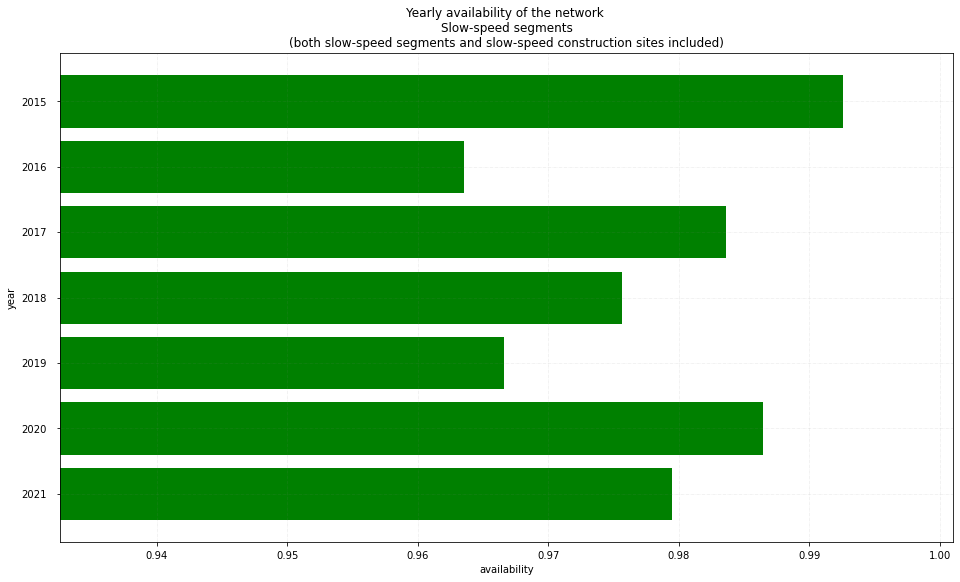

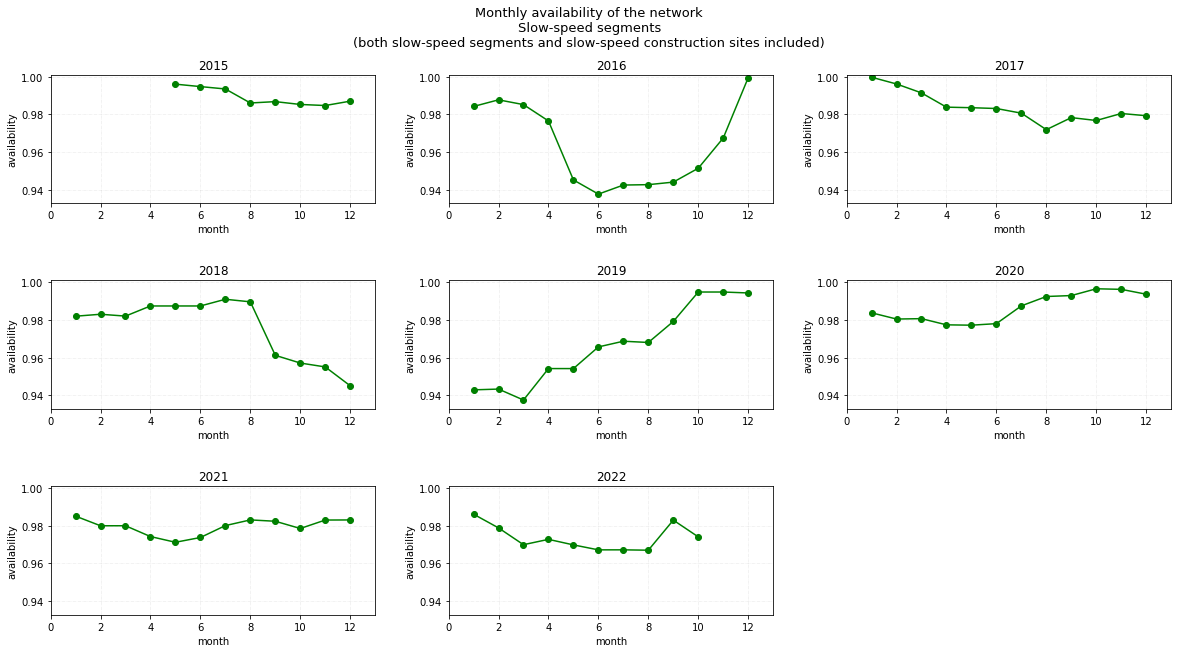

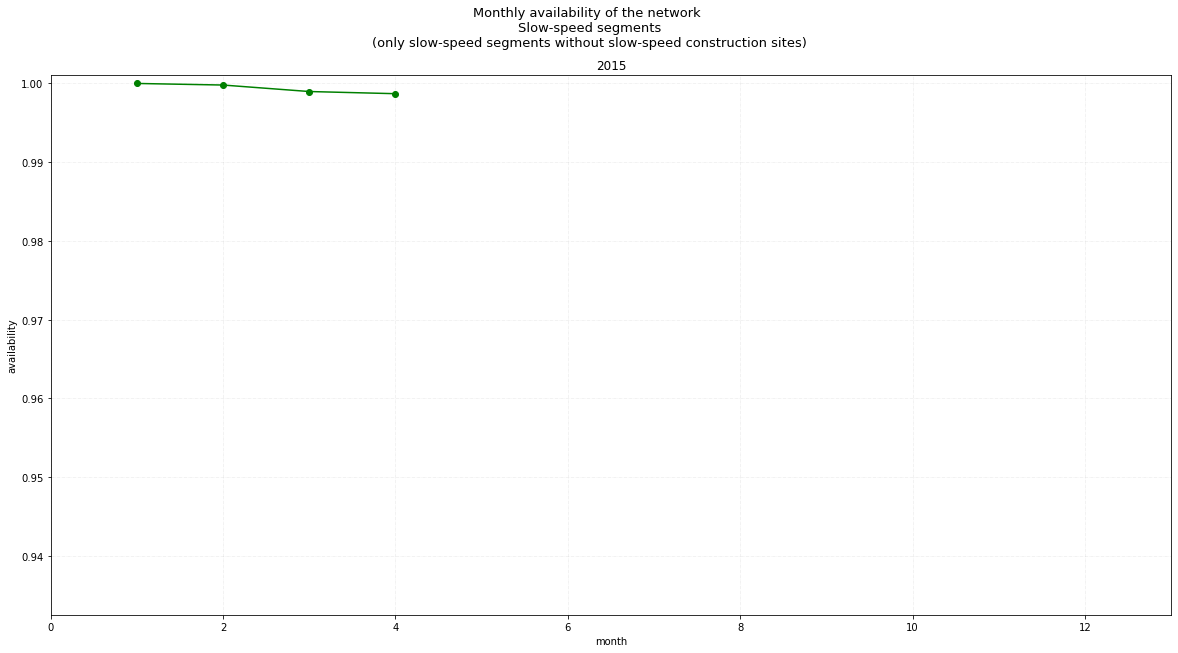

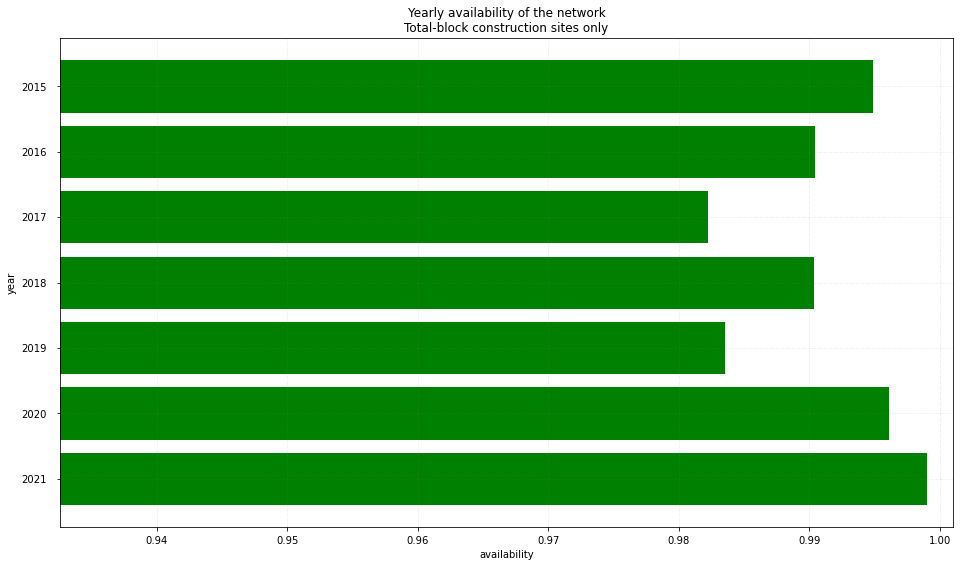

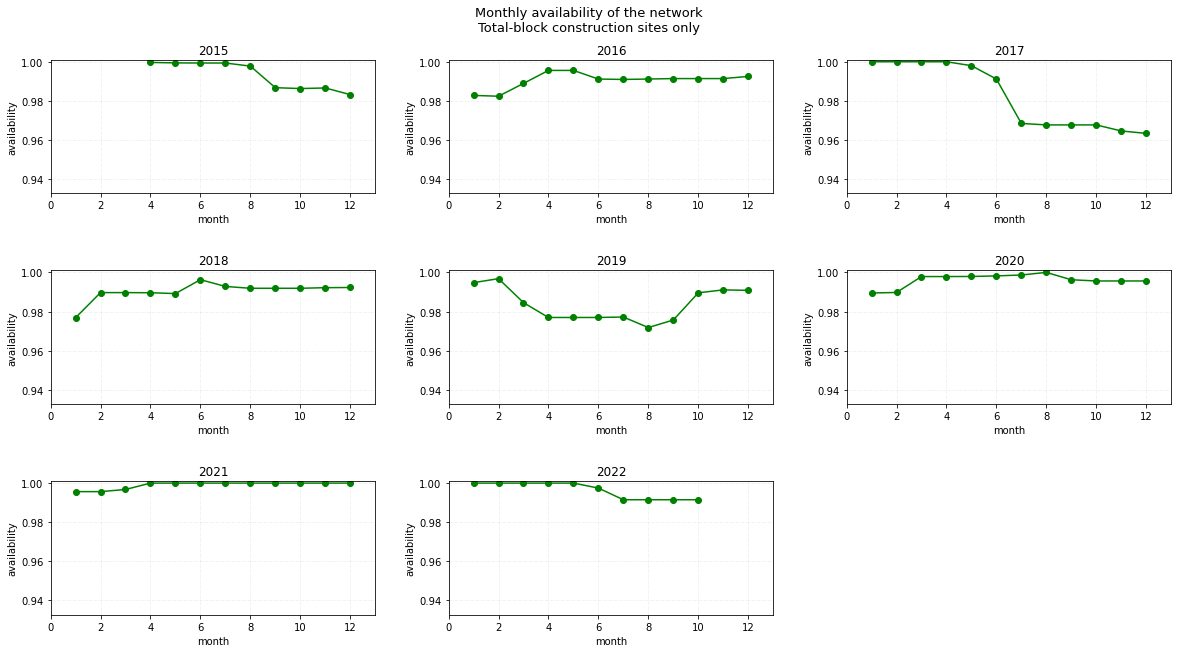

In [425]:
#
# Execute the functions
#

# Create geopandas geodataframes using the shapefiles above
# slow tracks
gdf_tracks = SHPtoGeodataframe(tracks)
# railway net
gdf_net = SHPtoGeodataframe(net)
# construction sites
gdf_construction_sites = SHPtoGeodataframe(construction_sites)

# convert string dates to datetime
gdf_tracks[[start_col_tracks, end_col_tracks]] = gdf_tracks[[start_col_tracks, end_col_tracks]].apply(makeDate) 
gdf_construction_sites[[start_col_sites, end_col_sites]] = gdf_construction_sites[[start_col_sites, end_col_sites]].apply(makeDate)

# Calculate the total length of the used rails
net_length = calculateTotalLength(gdf_net)

## Calculate availability of the net
# Slow-speed tracks
table_tracks_year = calculateAvailabilityYear(start_col_tracks, end_col_tracks, gdf_tracks, net_length, yearName = text[language].common.yearName, availabilityName = text[language].common.availabilityName)
table_tracks_month = calculateAvailabilityMonth(start_col_tracks, end_col_tracks, gdf_tracks, net_length, yearName = text[language].common.yearName, monthName = text[language].common.monthName, availabilityName = text[language].common.availabilityName)
# Construction sites, all four tables (monthly/yearly, total-block/non-total-block)
table_sites_total_block_year, table_sites_slow_tracks_year, table_sites_total_block_month, table_sites_slow_tracks_month = calculateAvailabilityConstructionSites(gdf_construction_sites, start_col_sites, end_col_sites, net_length, yearName = text[language].common.yearName, monthName = text[language].common.monthName, availabilityName = text[language].common.availabilityName, typeCol = SitesTypeCol, totalBlockName = TotalBlockDef)

# Slow speed tracks + slow-speed construction sites combined or told apart
# Three tables are possible
# Yearly
table_slow_speed_year, table_slow_tracks_year_onlytracks, table_slow_tracks_year_onlysites = calculateAvailabilitySlowTracks(table_tracks_year, table_sites_slow_tracks_year, yearName = text[language].common.yearName, monthName = text[language].common.monthName, availabilityName = text[language].common.availabilityName)
# Monthly
table_slow_speed_month, table_slow_tracks_month_onlytracks, table_slow_tracks_month_onlysites = calculateAvailabilitySlowTracks(table_tracks_month, table_sites_slow_tracks_month, yearName = text[language].common.yearName, monthName = text[language].common.monthName, availabilityName = text[language].common.availabilityName)

## Save the data
# Maket the lists for the data to export
list_dfs_total_block = [table_sites_total_block_year, table_sites_total_block_month]
list_dfs_slow_speed_year = [table_slow_speed_year, table_slow_tracks_year_onlytracks, table_slow_tracks_year_onlysites]
list_dfs_slow_speed_month = [table_slow_speed_month, table_slow_tracks_month_onlytracks, table_slow_tracks_month_onlysites]
# Save the data to the output filenames and using the sheet names provided 
saveData(list_dfs_total_block, outputFileName=text[language].excel.totalBlocks+excel_ext, 
         sheet_names=[text[language].sheet.yearlyData, text[language].sheet.monthlyData])
saveData(list_dfs_slow_speed_year, outputFileName=text[language].excel.slowTracksYear+excel_ext, 
         sheet_names=[text[language].sheet.combined, text[language].sheet.tracks, text[language].sheet.sites])
saveData(list_dfs_slow_speed_month, outputFileName=text[language].excel.slowTracksMonth+excel_ext, 
         sheet_names=[text[language].sheet.combined, text[language].sheet.tracks, text[language].sheet.sites])

## Plot and save charts
# Define the limits for the availability values
lowlim = min(table_tracks_year[text[language].common.availabilityName].min(), table_tracks_month[text[language].common.availabilityName].min(), 
   table_sites_total_block_year[text[language].common.availabilityName].min(), table_sites_slow_tracks_year[text[language].common.availabilityName].min(),
   table_sites_total_block_month[text[language].common.availabilityName].min(), table_sites_slow_tracks_month[text[language].common.availabilityName].min()) - 0.01
# lower limit variable according to the input data, upper limit set to 1.001
availabilityLimits = (lowlim, 1.001)

# Yerly charts slow-speed segments
# Slow-speed segments and slow-speed construction sites combined
#plot_yearly_chart(df, xlims, title, file, yearName='year', availabilityName='availability', xlabel='availability', ylabel='year'):
plot_yearly_chart(table_slow_speed_year, 
                  availabilityLimits, 
                  title=text[language].chartTitle.SlowTracksAllYear, 
                  file=text[language].plot.YearlySlowTracksAllFileName+img_ext, 
                  yearName=text[language].common.yearName, availabilityName=text[language].common.availabilityName,
                  xlabel=text[language].common.availabilityName, ylabel=text[language].common.yearName)
# Slow-speed segments only, without slow-speed construction sites
plot_yearly_chart(table_slow_tracks_year_onlytracks, 
                  availabilityLimits, 
                  title=text[language].chartTitle.SlowTracksOnlyTracksYear, 
                  file=text[language].plot.YearlySlowTracksOnlyTracksFileName+img_ext, 
                  yearName=text[language].common.yearName, availabilityName=text[language].common.availabilityName,
                  xlabel=text[language].common.availabilityName, ylabel=text[language].common.yearName)
# Slow-speed construction sites only, without slow-speed segments
plot_yearly_chart(table_slow_tracks_year_onlysites, 
                  availabilityLimits, 
                  title=text[language].chartTitle.SlowTracksOnlySitesYear, 
                  file=text[language].plot.YearlySlowTracksOnlySitesFileName+img_ext, 
                  yearName=text[language].common.yearName, availabilityName=text[language].common.availabilityName, 
                  xlabel=text[language].common.availabilityName, ylabel=text[language].common.yearName)

# Monthly charts slow-speed segments
# Slow-speed segments and slow-speed construction sites combined
plot_monthly_chart(table_slow_speed_month, 
                   availabilityLimits, 
                   title=text[language].chartTitle.SlowTracksAllMonth, 
                   file=text[language].plot.MonthlySlowTracksAllFileName+img_ext, 
                   yearName = text[language].common.yearName, monthName = text[language].common.monthName, availabilityName = text[language].common.availabilityName,
                   xlabel=text[language].common.monthName, ylabel=text[language].common.availabilityName)
# Slow-speed segments only, without slow-speed construction sites
plot_monthly_chart(table_slow_tracks_month_onlytracks, 
                   availabilityLimits, 
                   title=text[language].chartTitle.SlowTracksOnlyTracksMonth,
                   file=text[language].plot.MonthlySlowTracksOnlyTracksFileName+img_ext,
                   yearName = text[language].common.yearName, monthName = text[language].common.monthName, availabilityName = text[language].common.availabilityName,
                   xlabel=text[language].common.monthName, ylabel=text[language].common.availabilityName)
# Slow-speed construction sites only, without slow-speed segments
plot_monthly_chart(table_slow_tracks_month_onlysites, 
                   availabilityLimits, 
                   title=text[language].chartTitle.SlowTracksOnlySitesMonth,
                   file=text[language].plot.MonthlySlowTracksOnlySitesFileName+img_ext,
                   yearName = text[language].common.yearName, monthName = text[language].common.monthName, availabilityName = text[language].common.availabilityName,
                   xlabel=text[language].common.monthName, ylabel=text[language].common.availabilityName)

# Total-block construction sites only
# yearly
plot_yearly_chart(table_sites_total_block_year, 
                  availabilityLimits, 
                  title=text[language].chartTitle.TotalBlocksYear,
                  file=text[language].plot.YearlyTotalBlocksFileName+img_ext,
                  yearName=text[language].common.yearName, availabilityName=text[language].common.availabilityName,
                  xlabel=text[language].common.availabilityName, ylabel=text[language].common.yearName)
# monthly
plot_monthly_chart(table_sites_total_block_month,
                   availabilityLimits,
                   title=text[language].chartTitle.TotalBlocksMonth,
                   file=text[language].plot.MonthlyTotalBlocksFileName+img_ext,
                   yearName = text[language].common.yearName, monthName = text[language].common.monthName, availabilityName = text[language].common.availabilityName,
                   xlabel=text[language].common.monthName, ylabel=text[language].common.availabilityName)